<table style="width: 100%; border: none;">
  <tr style="border: none;">
    <td style="width: 15%; border: none; vertical-align: middle;">
      <img src="https://th.bing.com/th/id/OIP.zZshkvEYWRVv1orlaBMmjwHaHa?w=155&h=180&c=7&r=0&o=5&pid=1.7" alt="Logo UNALM" style="width: 100px;">
    </td>
    <td style="width: 85%; border: none; vertical-align: middle; text-align: left;">
      <h2 style="margin: 0; color: #1a4d2e;">UNIVERSIDAD NACIONAL AGRARIA LA MOLINA</h2>
      <h4 style="margin: 2px 0; color: #444;">FACULTAD DE ECONOMÍA Y PLANIFICACIÓN</h4>
      <h5 style="margin: 0; color: #666; font-weight: normal;">DEPARTAMENTO DE ESTADÍSTICA E INFORMÁTICA</h5>
    </td>
  </tr>
</table>

<hr style="border-top: 2px solid #1a4d2e; margin: 10px 0;">

<div style="padding: 10px;">
  <p style="font-size: 16px; margin: 5px 0;">
    <strong>Curso:</strong> LENGUAJE DE PROGRAMACIÓN II <br>
    <strong>Docente:</strong> Denisse Chalan
  </p>

  <h4 style="margin-top: 15px; color: #1a4d2e;">Integrantes:</h4>
  <ul style="line-height: 1.6;">
    <li>Ormeño Sakihama, Daniel Kenyi - (20240723)</li>
    <li>Apellido Paterno, Nombre - (Código)</li>
    <li>Apellido Paterno, Nombre - (Código)</li>
    <li>Apellido Paterno, Nombre - (Código)</li>
  </ul>
</div>

## 1. Introducción a la API de Datos Abiertos del Banco Mundial

La herramienta seleccionada para la extracción de datos en este proyecto es la **API (Interfaz de Programación de Aplicaciones) de Indicadores del Banco Mundial** (*World Bank Open Data API*).

Esta interfaz es fundamental para el análisis debido a sus características principales:

* **Robustez y Confiabilidad:** Es considerada una de las fuentes más sólidas a nivel global.
* **Accesibilidad:** Provee acceso programático directo a bases de datos oficiales.
* **Cobertura Multidisciplinaria:** Permite la obtención de información estadística vital sobre **desarrollo económico, demografía, salud y medio ambiente**.

## 2. Análisis descriptivo de Datos (API Banco Mundial)

En esta etapa, utilizaremos **Python** para extraer información actualizada directamente de los servidores del Banco Mundial. 

**Objetivo del Script:**
El propósito de este bloque de código no es solo visualizar una tabla, sino **construir y estructurar el conjunto de datos (DataFrame)** que servirá como base para la **generación de gráficos estadísticos** en la siguiente sección.

**El proceso consta de:**
1.  **Conexión:** Petición de datos macroeconómicos (PBI, Inflación, Gini, etc.) para 12 países de Sudamérica.
2.  **Limpieza:** Filtrado del año más reciente disponible (entre 2019-2024) para garantizar la actualidad del análisis.
3.  **Previsualización:** Muestra de un resumen tabular estilizado para validar que los datos se han cargado correctamente antes de graficar.

In [3]:
import requests
import pandas as pd

# ==========================================
# 1. CONFIGURACIÓN Y EXTRACCIÓN
# ==========================================
paises_sudamerica = ['ARG', 'BOL', 'BRA', 'CHL', 'COL', 'ECU', 'GUY', 'PRY', 'PER', 'SUR', 'URY', 'VEN']
codigos_paises = ';'.join(paises_sudamerica)

indicadores = {
    'NY.GDP.MKTP.CD': 'PBI_USD',           # PBI nominal
    'SP.POP.TOTL':    'Poblacion',         # Población total
    'SI.POV.NAHC':    'Pobreza_Nacional',  # % Pobreza
    'FP.CPI.TOTL.ZG': 'Inflacion_Anual',   # % Inflación
    'SI.POV.GINI':    'Indice_Gini'        # Desigualdad
}

def obtener_datos_wb(indicador, codigos_paises):
    url = f"http://api.worldbank.org/v2/country/{codigos_paises}/indicator/{indicador}?format=json&date=2019:2024&per_page=1000"
    try:
        response = requests.get(url)
        data = response.json()
        if len(data) < 2: return []
        resultados = []
        for item in data[1]:
            if item['value'] is not None:
                resultados.append({
                    'Codigo_ISO': item['countryiso3code'],
                    'País': item['country']['value'],
                    'Año': item['date'],
                    'Valor': item['value']
                })
        return resultados
    except Exception as e:
        print(f"Error: {e}")
        return []

print("⏳ Procesando datos del Banco Mundial para gráficos...", end="")
todos_los_datos = []

for codigo_ind, nombre_columna in indicadores.items():
    datos = obtener_datos_wb(codigo_ind, codigos_paises)
    df_temp = pd.DataFrame(datos)
    if not df_temp.empty:
        # Nos quedamos con el año más reciente por país
        df_temp = df_temp.sort_values('Año', ascending=False).drop_duplicates('Codigo_ISO')
        df_temp = df_temp[['Codigo_ISO', 'País', 'Valor']].rename(columns={'Valor': nombre_columna})
        todos_los_datos.append(df_temp)
    print(".", end="") 

# ==========================================
# 2. CONSOLIDACIÓN EN DATAFRAME
# ==========================================
if todos_los_datos:
    df_final = todos_los_datos[0]
    for df in todos_los_datos[1:]:
        df_final = pd.merge(df_final, df, on=['Codigo_ISO', 'País'], how='outer')

    # Conversión de unidades para mejor lectura en gráficos y tabla
    if 'PBI_USD' in df_final.columns:
        df_final['PBI (MM USD)'] = df_final['PBI_USD'] / 1e9
    if 'Poblacion' in df_final.columns:
        df_final['Pob (Millones)'] = df_final['Poblacion'] / 1e6
    
    # Preparamos una vista limpia para mostrar ahora (sin perder los datos originales en df_final)
    cols_mostrar = ['País', 'Codigo_ISO', 'PBI (MM USD)', 'Pob (Millones)', 'Indice_Gini', 'Inflacion_Anual']
    cols_existentes = [c for c in cols_mostrar if c in df_final.columns]
    
    # Creamos una copia solo para visualizar (df_vista), pero df_final sigue disponible para graficar luego
    df_vista = df_final[cols_existentes].copy().set_index('País')

    print(" ¡Datos listos!\n")

    # ==========================================
    # 3. PREVISUALIZACIÓN DE DATOS (TABLA RESUMEN)
    # ==========================================
    display(df_vista.style
        .format("{:.2f}", subset=['PBI (MM USD)', 'Pob (Millones)', 'Indice_Gini', 'Inflacion_Anual']) 
        .background_gradient(cmap='Blues', subset=['PBI (MM USD)'])   
        .background_gradient(cmap='Reds', subset=['Inflacion_Anual']) 
        .set_caption("Previsualización de Datos para Análisis Gráfico")
        .set_properties(**{'text-align': 'center'})
    )

else:
    print("❌ No se pudieron obtener datos.")

⏳ Procesando datos del Banco Mundial para gráficos........ ¡Datos listos!



,Codigo_ISO,PBI (MM USD),Pob (Millones),Indice_Gini,Inflacion_Anual
País,,,,,
Argentina,ARG,638.37,45.70,42.40,219.88
Bolivia,BOL,54.88,12.41,42.10,5.10
Brazil,BRA,2185.82,212.00,51.60,4.37
Chile,CHL,330.27,19.76,43.00,4.30
Colombia,COL,418.82,52.89,53.90,6.61
Ecuador,ECU,124.68,18.14,45.20,1.55
Guyana,GUY,24.66,0.83,nan,2.90
Peru,PER,289.22,34.22,40.10,2.01
Paraguay,PRY,44.46,6.93,44.20,3.84


### 📊 1. Mapa de Calor: El "Termómetro" de la Inflación

Este gráfico funciona como una alerta visual para identificar la estabilidad monetaria en la región.
* **Colores Rojos Intensos:** Indican economías con **alta inflación**. En estos países, los precios suben rápidamente, lo que erosiona el poder adquisitivo de las personas.
* **Colores Claros:** Indican **estabilidad**. El dinero mantiene su valor en el tiempo.

**Conclusión:** Podemos identificar rápidamente los focos de riesgo económico en Sudamérica y contrastarlos con los países que mantienen políticas monetarias estables.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de Estilo General
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Aseguramos que el DataFrame 'df' tenga el índice correcto si no lo tiene
if 'País' in df.columns:
    df = df.set_index('País')
    
# Filtramos y ordenamos
if 'Inflacion_Anual' in df.columns:
    df_inflacion = df[['Inflacion_Anual']].sort_values(by='Inflacion_Anual', ascending=False)

    plt.figure(figsize=(6, 8))
    
    sns.heatmap(df_inflacion, 
                annot=True,            # Muestra el número
                cmap='Reds',           # Rojo = Peligro
                fmt=".1f",             # 1 decimal
                cbar_kws={'label': 'Inflación Anual (%)'},
                linewidths=1, linecolor='white') # Bordes para limpieza visual
    
    plt.title('Ranking de Inflación Anual (%)\n(Más rojo = Mayor inestabilidad)', fontsize=14)
    plt.tight_layout()
    plt.show()

### 📊 2. Desigualdad Social (Índice Gini)

El PBI nos dice cuánto dinero tiene un país, pero el **Índice Gini** nos dice cómo se reparte ese dinero.
* **Barras más largas (Cercanas a 100):** Indican mayor desigualdad. La brecha entre ricos y pobres es muy amplia.
* **Barras más cortas (Cercanas a 0):** Indican una distribución de riqueza más equitativa.

**Análisis:** Este ranking nos permite ver qué países, independientemente de su riqueza total, han logrado construir sociedades más justas en términos económicos.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27120\3059645022.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(x=df_gini['Indice_Gini'], y=df_gini.index, palette='viridis')


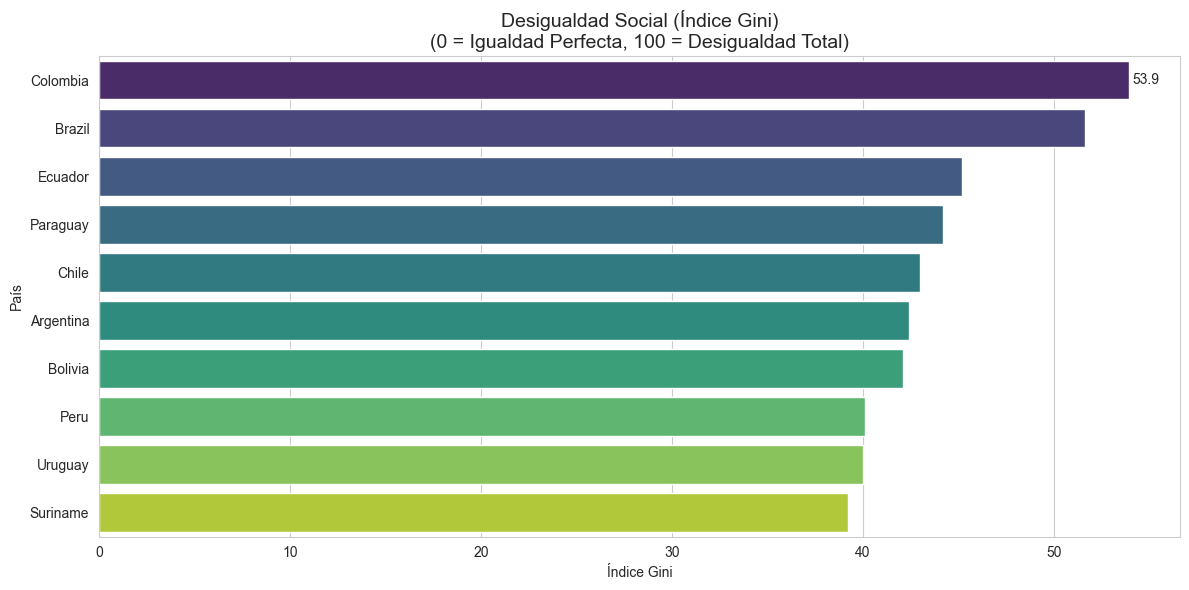

In [9]:
if 'Indice_Gini' in df.columns:
    # Ordenamos de mayor a menor desigualdad
    df_gini = df.sort_values('Indice_Gini', ascending=False)

    plt.figure(figsize=(12, 6))
    
    grafico = sns.barplot(x=df_gini['Indice_Gini'], y=df_gini.index, palette='viridis')
    
    plt.title('Desigualdad Social (Índice Gini)\n(0 = Igualdad Perfecta, 100 = Desigualdad Total)', fontsize=14)
    plt.xlabel('Índice Gini')
    
    # Etiquetas de valor al final de las barras
    plt.bar_label(grafico.containers[0], fmt='%.1f', padding=3)
    
    plt.tight_layout()
    plt.show()

### 📊 3. Correlación: Inflación vs. Pobreza

Este gráfico de dispersión busca responder: **¿La subida de precios genera más pobreza?**
Dividimos el gráfico en cuadrantes usando el promedio regional (líneas punteadas):
1.  **Cuadrante Superior Derecho:** Países con el "doble castigo" (Alta Inflación y Alta Pobreza). Son los casos más críticos.
2.  **Cuadrante Inferior Izquierdo:** El escenario ideal (Baja Inflación y Baja Pobreza).

**Interpretación:** La ubicación de los puntos nos ayuda a entender si la inestabilidad de precios está golpeando a los sectores más vulnerables de cada país.

In [12]:
if 'Inflacion_Anual' in df.columns and 'Pobreza_Nacional' in df.columns:
    plt.figure(figsize=(12, 8))
    
    # Gráfico de dispersión
    sns.scatterplot(data=df, x='Inflacion_Anual', y='Pobreza_Nacional', 
                    s=200, color='darkorange', alpha=0.8, edgecolor='black')

    # Nombres de los países
    for pais in df.index:
        plt.text(df.loc[pais, 'Inflacion_Anual']+0.2, 
                 df.loc[pais, 'Pobreza_Nacional'], 
                 pais, fontsize=9, fontweight='bold')

    # Líneas promedio (Cuadrantes)
    plt.axvline(x=df['Inflacion_Anual'].mean(), color='red', linestyle='--', alpha=0.5, label='Promedio Inflación')
    plt.axhline(y=df['Pobreza_Nacional'].mean(), color='blue', linestyle='--', alpha=0.5, label='Promedio Pobreza')
    plt.legend()

    plt.title('Impacto de la Inflación en la Pobreza Nacional', fontsize=14)
    plt.xlabel('Inflación Anual (%)')
    plt.ylabel('Tasa de Pobreza Nacional (%)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

### 📊 4. Riqueza Promedio por Habitante (PBI Per Cápita)

Este indicador elimina el "efecto tamaño". Brasil tiene una economía gigante porque tiene mucha población, pero eso no significa que el ciudadano promedio sea rico.
* **El cálculo:** Dividimos el PBI Total entre la Población Total.
* **El resultado:** Obtenemos una aproximación del ingreso promedio anual por persona en dólares.

**Conclusión:** Este ranking refleja mejor la **calidad de vida y poder de consumo** promedio. Vemos cómo países pequeños pueden superar a economías grandes cuando ajustamos por población.

In [14]:
# Validamos columnas necesarias (ajusta los nombres si usaste otros en la descarga)
# Intentamos usar nombres genéricos o los calculamos
col_pbi = 'PBI_Billions' if 'PBI_Billions' in df.columns else 'PBI (MM USD)'
col_pob = 'Poblacion_Millones' if 'Poblacion_Millones' in df.columns else 'Pob (Millones)'

if col_pbi in df.columns and col_pob in df.columns:
    # Calculamos PBI Per Cápita (Miles de Millones / Millones * 1000 = USD)
    df['PBI_Per_Capita'] = (df[col_pbi] / df[col_pob]) * 1000
    
    # Ordenamos
    df_per_capita = df.sort_values('PBI_Per_Capita', ascending=False)

    plt.figure(figsize=(12, 6))
    
    grafico = sns.barplot(x=df_per_capita['PBI_Per_Capita'], y=df_per_capita.index, palette='Blues_d')
    
    plt.title('Ranking de Riqueza Real: PBI Per Cápita (USD)', fontsize=14)
    plt.xlabel('Dólares anuales por habitante (USD)')
    
    # Formato de moneda ($)
    for i, container in enumerate(grafico.containers):
        grafico.bar_label(container, fmt='$ %.0f', padding=3)

    plt.tight_layout()
    plt.show()